In [71]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
import sys

from astropy.utils.data import get_pkg_data_filename

from astropy import units as u
from poliastro.bodies import Earth, Sun
from poliastro.twobody import Orbit
from astropy.coordinates import SkyCoord
from astropy.coordinates import GCRS
from astropy.coordinates import get_moon
from astropy.time import Time

In [2]:
#likelihood (just a product of the single image likelihoods )
def likelihood(img_liks):
    return np.product(img_liks)

In [ ]:
#a marginalization over time, we will be using an evenly spaced grid of times
#we need to compute one single likelihood 
single_image_likelihood():
    

In [64]:
#function that takes the position and velocity vectors at a certain epoch and returns the ICRS coordinates of the
#object over a time grid (these are approximately ICRS, but the orbit is really around the CM of the sun and
#not the solar system barycenter)
#r and v are three element lists that represent vectors and need to have the proper units appended
def orbit_sim(r, v, epoch, t_i, t_f, n_points):
    #making a list of times to sample:
    times = np.linspace(t_i, t_f, n_points)
    
    #making the propagation delta
    prop_delta = [(i - epoch)*u.day for i in times]
    
    #defining orbit object
    orbit = Orbit.from_vectors(Sun, r, v)
    
    #initialize array to store the positions
    locations = [0 for i in range(n_points)]
    
    #looping over linspace to evaluate the orbit at all of these points
    for i in range(len(prop_delta)):
        locations[i] = orbit.propagate(prop_delta[i]).rv()[0]
    
    return [locations, times]

In [84]:
#function that takes the cartesian (x,y,z) in ICRS frame and returns the ra and dec as seen from the earth
def ICRS_to_GCRS(positions, times):
    
    coords = [0 for i in range(len(times))]
    
    
    for i in range(len(positions)):
        temp_time = Time(times[i], format='jd')
        X,Y,Z = positions[i].value
        temp_coord = SkyCoord(x = X, y = Y, z = Z, unit='km' ,frame = 'icrs' , representation_type = 'cartesian', obstime=temp_time)
        cor = temp_coord.transform_to('gcrs')
        coords[i] = [cor.ra.value, cor.dec.value]
    
    
    return coords
        

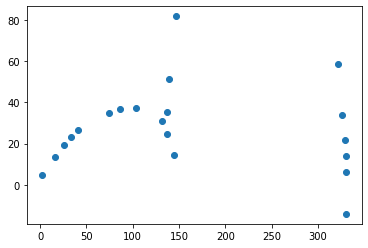

In [102]:
simulated = orbit_sim([10**8,10**8,10**8]*u.km, [0,0,5]*u.km/u.s, 2454416, 2454283.5, 2454587.5, 20)
RaDec = ICRS_to_GCRS(simulated[0], simulated[1])
plt.scatter(np.transpose(RaDec)[0], np.transpose(RaDec)[1])

In [ ]:
#takes a plt.imread image, WCS object from .wcs file, eta (0,1), and point is a SkyCoord object
#deterimines if point is in the eta subimage of the image as defined in the paper

def subimage_contains(img, wcs_func, eta, point):
    
    #assigning variables to the image dimensions
    a,b = img.shape[:2]
    
    #variable assignments that have to do with determining whether the point is in the eta subimage
    r_eta = np.sqrt(eta)
    am = int(a*(1-r_eta)/2)
    ap = int(a*(1+r_eta)/2)
    bm = int(b*(1-r_eta)/2)
    bp = int(b*(1+r_eta)/2)
    
    #boolean values 
    Abool = point.contained_by(wcs_func, image = np.ones((b,am)))
    Bbool = point.contained_by(wcs_func, image = np.ones((bm,a)))
    Cbool = point.contained_by(wcs_func, image = np.ones((bp,ap)))
    
    #boolshit
    final_bool = (not Abool) and (not Bbool) and (Cbool)
    
    return final_bool

In [ ]:
from astropy import wcs

In [ ]:
num_param = '0027'

image_array = plt.imread('../Data_CometHolmes/holmes-%s.jpg'%(num_param))
print(image_array.shape)
image_shape = np.ones(image_array.shape[:2])
world_coord = wcs.WCS('../Data_CometHolmes/holmes-%s.wcs'%(num_param))

#plt.imshow(image_array)
pixel_coords = np.ones((len(image_array)*len(image_array[0]), 2))
#loop through the array and make pixel coords at each point, might have to flip axes

foot_print = world_coord.calc_footprint(axes = [len(image_array),len(image_array[0])])
print("Footprint: ", foot_print)

    
#print(spot_test.contained_by(world_coord, image = image_shape[:400])) #how does the footprint work?
print(spot_test.contained_by(world_coord, image = np.ones((100,600))))

##CHOOSE COORDINATE SYSTEM THAT IS CORRECT, MIGHT BE LITTLE ERRORS IN THE CONTAINED_BY METHOD

##HOW TO DO SUBIMAGE DESCRIBED IN THE PAPER???
eta = 0.8
#r_eta = np.sqrt(eta)
#in_subimage = False
#a,b = image_array.shape[:2]
#am is "a minus" to denote the relevant values
#am = int(a*(1-r_eta)/2)
#ap = int(a*(1+r_eta)/2)
#bm = int(b*(1-r_eta)/2)
#bp = int(b*(1+r_eta)/2)

validRA = []
validDEC = []
for i in sky_coords:
    
    if subimage_contains(image_array, world_coord, eta, i):
        validRA.append(i.ra.degree)
        validDEC.append(i.dec.degree)


##LOOK AT SUBIMAGE DOCUMENTATION, try specifying image dimension in footprint_contains

for i in range(len(image_array)):
    for j in range(len(image_array[0])):
        index = i*len(image_array[0]) + j
        pixel_coords[index][0] = i
        pixel_coords[index][1] = j

trans_coords = np.transpose(world_coord.wcs_pix2world(pixel_coords, 0))
plt.scatter(trans_coords[0], trans_coords[1], color='k');
plt.scatter(np.transpose(foot_print)[0], np.transpose(foot_print)[1],color='b')
plt.scatter([spot_test.ra.degree],[spot_test.dec.degree],color='b')
plt.scatter(validRA,validDEC,color='g')